In [1]:
import pandas as pd
import numpy as np
import sklearn
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
import joblib
import os, random
from omnixai.data.tabular import Tabular
from omnixai.preprocessing.tabular import TabularTransform
from omnixai.explainers.tabular import TabularExplainer

# Load and preprocess data

In [2]:
# Load dataset
columns = [
    "age", "workclass", "fnlwgt", "education", "education_num",
    "marital_status", "occupation", "relationship", "race", "sex",
    "capital_gain", "capital_loss", "hours_per_week", "native_country", "income"
]

# df = pd.read_csv('../adult/adult.data', names=columns,na_values=' ?')
df = pd.DataFrame(
    np.genfromtxt('../adult.data', delimiter=', ', dtype=str),
    columns=columns
)

df.replace(['?'], np.nan, inplace=True)
df.dropna(inplace=True)

# Declare categorical columns
categorical_columns = [
    "workclass", "education", "marital_status", "occupation", "relationship", "race", "sex", "native_country", "income"
]

for feature in columns:
    if feature in categorical_columns:
        df[feature] = df[feature].astype("category")
    else:
        print(feature)
        df[feature] = df[feature].astype("int")

#create bins for hours per week
# df["hours_per_week"] = pd.cut(
#     x=df["hours_per_week"],
#     bins=[0.9, 25, 39, 40, 55, 100],
#     labels=["PartTime", "MidTime", "FullTime", "OverTime", "BrainDrain"]
# )

df['income'] = df['income'].apply(lambda x:x.strip())
df['income'] = df['income'].apply(lambda x: 1 if x=='>50K' else 0)
df['age'] = df['age'].apply(lambda x: "Senior" if x>25 else "Young")
df['age_cat'] = df['age'].apply(lambda x: 1 if x == "Senior" else 0)
df['sex_cat'] = df['sex'].apply(lambda x: 1 if x == " Male" else 0)
df['age_cat_private'] = df['age_cat']
df['sex_cat_private'] = df['sex_cat']
df["relationship"] = df["relationship"].replace('Husband','Married')
df["relationship"] = df["relationship"].replace('Wife','Married')

age
fnlwgt
education_num
capital_gain
capital_loss
hours_per_week


In [3]:
df.head()

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income,age_cat,sex_cat,age_cat_private,sex_cat_private
0,Senior,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,0,1,0,1,0
1,Senior,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Married,White,Male,0,0,13,United-States,0,1,0,1,0
2,Senior,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,0,1,0,1,0
3,Senior,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Married,Black,Male,0,0,40,United-States,0,1,0,1,0
4,Senior,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Married,Black,Female,0,0,40,Cuba,0,1,0,1,0


In [4]:
df.shape

(30162, 19)

# Create private data

In [5]:
def get_p_q(epsilon):
    p = np.exp(epsilon)/(1+np.exp(epsilon))
    return p, p

def rand_resp(x, epsilon):
    p = np.exp(epsilon) / (np.exp(epsilon) + 1)
    toss = np.random.random()
    if x == 0:
        y = 0 if toss <= p else 1
    else:
        y = 1 if toss <= p else 0
    return y

def apply_ldp(data, sensitive_columns, epsilon):
    print(f"Applying LDP with epsilon = {epsilon}")
    private_data = data.copy()

    for col in sensitive_columns:
        private_data[f"{col}_private"] = private_data[col].apply(lambda x: rand_resp(x,epsilon))

    return private_data

In [6]:
sensitive_attributes = ['age_cat','sex_cat']
epsilon = 0.5
df_private = apply_ldp(df, sensitive_attributes, epsilon)

Applying LDP with epsilon = 0.5


In [7]:
df_private.head()

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income,age_cat,sex_cat,age_cat_private,sex_cat_private
0,Senior,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,0,1,0,0,0
1,Senior,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Married,White,Male,0,0,13,United-States,0,1,0,0,0
2,Senior,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,0,1,0,1,1
3,Senior,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Married,Black,Male,0,0,40,United-States,0,1,0,1,1
4,Senior,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Married,Black,Female,0,0,40,Cuba,0,1,0,1,0


In [8]:
df_private.shape

(30162, 19)

In [9]:
os.makedirs('../data', exist_ok=True)
df_private.to_csv('../data/private_data.csv')

# Split private data

In [10]:
# X = df_private.drop(columns=['age', 'sex', 'age_cat', 'sex_cat', 'income'], axis=1)
# y = df_private['income']
# X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# train_data = X_train_val.copy()
# train_data['income'] = y_train_val
# test_data = X_test.copy()
# test_data['income'] = y_test
# train_data = train_data.dropna().reset_index(drop=True)
# test_data = test_data.dropna().reset_index(drop=True)

# print(f'Train data: {train_data.shape}')
# print(f'Test data: {test_data.shape}')

# Split private data and train the private classifier

In [11]:
df_priv = df_private.drop(columns=['age', 'sex', 'age_cat', 'sex_cat'], axis=1)
private_tabular = Tabular(
    df_priv,
    categorical_columns=['workclass', 'education', 'marital_status', 'occupation',
                         'relationship', 'race', 'native_country', 'age_cat_private'],
    target_column='income'
)

df_priv.head(2)

,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,capital_gain,capital_loss,hours_per_week,native_country,income,age_cat_private,sex_cat_private
0,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,2174,0,40,United-States,0,0,0
1,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Married,White,0,0,13,United-States,0,0,0


In [12]:
print(private_tabular.data.shape)
private_tabular.data.head(2)

(30162, 15)


,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,capital_gain,capital_loss,hours_per_week,native_country,income,age_cat_private,sex_cat_private
0,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,2174,0,40,United-States,0,0,0
1,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Married,White,0,0,13,United-States,0,0,0


In [13]:
transformer = TabularTransform().fit(private_tabular)
class_names = transformer.class_names
X = transformer.transform(private_tabular)

In [14]:
x = X[:, :-1]
y = X[:, -1]
train, test, train_labels, test_labels = sklearn.model_selection.train_test_split(x, y, test_size=0.2, random_state=42, stratify=y)

test_labels = test_labels.astype(int)

print('Training data shape: {}'.format(train.shape))
print('Test data shape:     {}'.format(test.shape))

Training data shape: (24129, 103)
Test data shape:     (6033, 103)


In [15]:
model = LGBMClassifier(objective="binary", verbose=-1)
model.fit(train, train_labels)

predict_function: lambda z: model.predict_proba(transformer.transform(z))

In [16]:
train_tabular = transformer.invert(train)
test_tabular = transformer.invert(test)

In [17]:
test_df = test_tabular.to_pd()
test_df['income'] = test_labels
predictions = model.predict(test)
predictions = predictions.astype(int)
test_df['prediction'] = predictions

test_df.head()

,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,capital_gain,capital_loss,hours_per_week,native_country,age_cat_private,sex_cat_private,income,prediction
0,Private,162034.0,Bachelors,13.0,Married-civ-spouse,Sales,Married,White,0.0,0.0,70.0,United-States,0,0.0,0,1
1,Private,245661.0,HS-grad,9.0,Separated,Machine-op-inspct,Own-child,White,0.0,0.0,40.0,United-States,0,0.0,0,0
2,Private,402998.0,Bachelors,13.0,Married-civ-spouse,Prof-specialty,Married,White,0.0,0.0,58.0,United-States,1,0.0,1,1
3,Private,142383.0,Assoc-acdm,12.0,Never-married,Sales,Not-in-family,Other,0.0,0.0,36.0,United-States,1,0.0,0,0
4,Private,211032.0,Preschool,1.0,Married-civ-spouse,Farming-fishing,Other-relative,White,41310.0,0.0,24.0,Mexico,1,0.0,0,1


Test: accuracy=0.8621
Test: TP=943, TN=4258, FP=273, FN=559


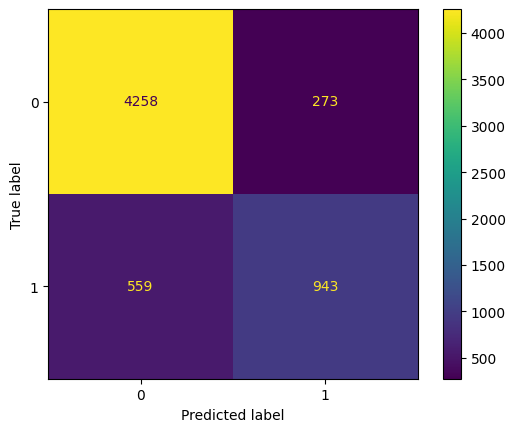

In [18]:
accuracy = sklearn.metrics.accuracy_score(test_labels, predictions)
print(f'Test: {accuracy=:.4f}')

cm = sklearn.metrics.confusion_matrix(test_labels, predictions)

TN = cm[0][0]
FN = cm[1][0]
TP = cm[1][1]
FP = cm[0][1]
print(f"Test: {TP=}, {TN=}, {FP=}, {FN=}")

disp = sklearn.metrics.ConfusionMatrixDisplay(confusion_matrix=cm, )
disp.plot();

In [19]:
os.makedirs('../model/lgbm_explainability', exist_ok=True)
epsilon_value = 0.5
joblib.dump(transformer,f"../model/lgbm_explainability/preprocessing_explainability_{epsilon_value}.pkl")
joblib.dump(model,f"../model/lgbm_explainability/lgbm_explainability_{epsilon_value}.pkl")

['../model/lgbm_explainability/lgbm_explainability_0.5.pkl']

# Explainability on private data

## Global explainability

In [20]:
train_tabular.data.head(2)

,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,capital_gain,capital_loss,hours_per_week,native_country,age_cat_private,sex_cat_private
0,Private,198870.0,Bachelors,13.0,Never-married,Adm-clerical,Own-child,Black,0.0,0.0,35.0,United-States,0,0.0
1,Federal-gov,119832.0,Some-college,10.0,Married-civ-spouse,Adm-clerical,Married,White,7298.0,0.0,40.0,United-States,1,0.0


In [21]:
train_tabular.data.shape

(24129, 14)

In [22]:
explainers = TabularExplainer(
    explainers=["ale", "shap_global"],                      # The explainers to apply
    mode="classification",                                  # The task type
    data=train_tabular,                                        # The data for initializing the explainers
    model=model,                                   # The ML model to explain
    preprocess=lambda z: transformer.transform(z),   # Converts raw features into the model inputs
)

In [23]:
global_explanations = explainers.explain_global()

  0%|          | 0/100 [00:00<?, ?it/s]

In [24]:
print("ALE results:")
global_explanations["ale"].ipython_plot(class_names=transformer.class_names)

ALE results:


In [25]:
print("SHAP results:")
global_explanations["shap_global"].ipython_plot(class_names=transformer.class_names, max_display=14)

SHAP results:


## Local explainability

In [26]:
train_tabular.data.head()

,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,capital_gain,capital_loss,hours_per_week,native_country,age_cat_private,sex_cat_private
0,Private,198870.0,Bachelors,13.0,Never-married,Adm-clerical,Own-child,Black,0.0,0.0,35.0,United-States,0,0.0
1,Federal-gov,119832.0,Some-college,10.0,Married-civ-spouse,Adm-clerical,Married,White,7298.0,0.0,40.0,United-States,1,0.0
2,Private,122272.0,Bachelors,13.0,Never-married,Adm-clerical,Own-child,White,0.0,0.0,30.0,United-States,1,0.0
3,Private,87507.0,Doctorate,16.0,Married-civ-spouse,Prof-specialty,Married,Asian-Pac-Islander,0.0,0.0,60.0,India,0,0.0
4,Private,245302.0,Some-college,10.0,Divorced,Sales,Own-child,Black,0.0,0.0,40.0,United-States,0,0.0


In [27]:
explainers = TabularExplainer(
    explainers=['lime', 'mace'],                       # The explainers to apply
    mode="classification",                             # The task type
    data=train_tabular,                                   # The data for initializing the explainers
    model=model,                               # The ML model to explain
    preprocess=lambda z: transformer.transform(z),  # Converts raw features into the model inputs
    params={
        "mace": {"ignored_features": ["sex_cat_private", "race"]}  # params which cannot change when creating counterfactuals
    }
)


In [28]:
instance_ids = random.choices(list(test_tabular.data.index), k=5)
print(f'Randomized instance ids: {instance_ids}')
test_instances = test_tabular[instance_ids]
local_explanations = explainers.explain(X=test_instances)

Randomized instance ids: [2196, 3894, 2271, 385, 1087]


In [29]:
print("LIME results:")
for i, instance_id in enumerate(instance_ids):
    print(f"Instance {instance_id} has label {test_labels[instance_id]} and prediction {model.predict(test[instance_id:instance_id+1])}, with probs {model.predict_proba(test[instance_id:instance_id+1])[0]}")
    local_explanations["lime"].ipython_plot(index=i, class_names=transformer.class_names)

LIME results:
Instance 2196 has label 0 and prediction [0.], with probs [0.84274257 0.15725743]


Instance 3894 has label 1 and prediction [1.], with probs [0.45983401 0.54016599]


Instance 2271 has label 0 and prediction [0.], with probs [0.96439313 0.03560687]


Instance 385 has label 0 and prediction [0.], with probs [0.99373332 0.00626668]


Instance 1087 has label 0 and prediction [0.], with probs [0.99597918 0.00402082]


## Counterfactual explanations

In [30]:
print("MACE results:")


for expl_id, instance_id in enumerate(instance_ids):
    
    query_df = local_explanations['mace'].get_explanations()[expl_id]['query'].reset_index(drop=True)
    query_df.index = [f"{instance_id}"] * len(query_df)
    # display(query_df)


    counter_df = local_explanations['mace'].get_explanations()[expl_id]['counterfactual'].reset_index(drop=True)
    counter_df.index = [ f"CF[{cnt}] for {instance_id}" for cnt in range(len(counter_df))]
    # display(counter_df)

    combined_df = pd.concat([query_df, counter_df])


    # Highlighting function
    def highlight_changes(row):
        instance_row = combined_df.iloc[0]  # Reference row for the instance
        return ["color: red" if row[col] != instance_row[col] else "" for col in combined_df.columns]

    # Apply the style
    styled_df = combined_df.style.apply(highlight_changes, axis=1)
    
    # Display the styled dataframe
    display(styled_df) 



MACE results:


,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,capital_gain,capital_loss,hours_per_week,native_country,age_cat_private,sex_cat_private,label
2196,Self-emp-not-inc,152493.000000,HS-grad,9.000000,Married-civ-spouse,Farming-fishing,Married,White,0.000000,0.000000,70.000000,United-States,1,0.000000,0
CF[0] for 2196,Local-gov,152493.000000,HS-grad,9.000000,Married-civ-spouse,Exec-managerial,Married,White,0.000000,0.000000,70.000000,United-States,1,0.000000,1
CF[1] for 2196,Local-gov,152387.875000,HS-grad,9.000000,Married-civ-spouse,Exec-managerial,Married,White,0.000000,0.000000,70.000000,United-States,1,0.000000,1
CF[2] for 2196,Local-gov,152493.000000,HS-grad,9.000000,Married-civ-spouse,Exec-managerial,Married,White,0.000000,0.000000,69.375000,United-States,1,0.000000,1
CF[3] for 2196,Self-emp-not-inc,152493.000000,HS-grad,9.000000,Married-civ-spouse,Farming-fishing,Married,White,0.000000,1848.000000,70.000000,United-States,1,0.000000,1
CF[4] for 2196,Self-emp-not-inc,152493.000000,HS-grad,9.000000,Married-civ-spouse,Farming-fishing,Married,White,0.000000,1848.000000,71.812500,United-States,1,0.000000,1


,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,capital_gain,capital_loss,hours_per_week,native_country,age_cat_private,sex_cat_private,label
3894,Private,163396.000000,Assoc-voc,11.000000,Married-civ-spouse,Prof-specialty,Married,White,0.000000,0.000000,40.000000,United-States,0,0.000000,1
CF[0] for 3894,Private,163396.000000,Assoc-voc,11.000000,Married-civ-spouse,Adm-clerical,Married,White,0.000000,0.000000,40.000000,United-States,0,0.000000,0
CF[1] for 3894,Private,163396.000000,Assoc-voc,11.000000,Married-civ-spouse,Adm-clerical,Married,White,0.000000,0.000000,39.750000,United-States,0,0.000000,0
CF[2] for 3894,Private,163857.406250,Assoc-voc,11.000000,Married-civ-spouse,Machine-op-inspct,Married,White,0.000000,0.000000,40.312500,United-States,0,0.000000,0
CF[3] for 3894,Private,163396.000000,Assoc-acdm,11.000000,Married-civ-spouse,Prof-specialty,Married,White,0.000000,789.500000,40.000000,United-States,0,0.000000,0
CF[4] for 3894,Private,163396.000000,Assoc-voc,11.000000,Married-civ-spouse,Prof-specialty,Married,White,0.000000,829.750000,40.000000,United-States,0,0.000000,0


,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,capital_gain,capital_loss,hours_per_week,native_country,age_cat_private,sex_cat_private,label
2271,Private,145231.000000,Assoc-acdm,12.000000,Divorced,Adm-clerical,Own-child,White,0.000000,1762.000000,40.000000,United-States,1,0.000000,0
CF[0] for 2271,Private,145231.000000,Assoc-acdm,12.000000,Divorced,Adm-clerical,Own-child,White,0.000000,2409.562500,41.625000,United-States,1,0.000000,1
CF[1] for 2271,Private,147298.562500,Assoc-acdm,12.000000,Divorced,Adm-clerical,Own-child,White,0.000000,2409.562500,41.625000,United-States,1,0.000000,1
CF[2] for 2271,Private,145231.000000,Assoc-acdm,12.000000,Divorced,Exec-managerial,Own-child,White,0.000000,2409.562500,41.625000,United-States,1,0.000000,1
CF[3] for 2271,Private,147298.562500,Assoc-acdm,12.250000,Married-civ-spouse,Tech-support,Own-child,White,4805.000000,1762.000000,40.000000,United-States,0,0.000000,1
CF[4] for 2271,Private,145231.000000,Masters,12.000000,Divorced,Exec-managerial,Not-in-family,White,7207.500000,1762.000000,40.000000,United-States,0,0.000000,1


,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,capital_gain,capital_loss,hours_per_week,native_country,age_cat_private,sex_cat_private,label
385,Private,149734.000000,HS-grad,9.000000,Separated,Craft-repair,Unmarried,Black,0.000000,1594.000000,40.000000,United-States,0,1.000000,0
CF[0] for 385,Private,149734.000000,HS-grad,9.000000,Separated,Craft-repair,Married,Black,0.000000,1805.750000,40.000000,United-States,0,1.000000,1
CF[1] for 385,Private,149734.000000,HS-grad,9.062500,Separated,Craft-repair,Married,Black,0.000000,1805.750000,40.000000,United-States,0,1.000000,1
CF[2] for 385,Private,149450.281250,HS-grad,9.062500,Separated,Craft-repair,Married,Black,0.000000,1805.750000,40.000000,United-States,0,1.000000,1
CF[3] for 385,Private,149734.000000,HS-grad,9.000000,Separated,Craft-repair,Unmarried,Black,7207.500000,1594.000000,40.500000,United-States,1,1.000000,1
CF[4] for 385,Private,149734.000000,HS-grad,8.875000,Married-civ-spouse,Craft-repair,Unmarried,Black,7207.500000,1594.000000,40.000000,United-States,1,1.000000,1


,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,capital_gain,capital_loss,hours_per_week,native_country,age_cat_private,sex_cat_private,label
1087,Private,111883.000000,HS-grad,9.000000,Never-married,Craft-repair,Other-relative,White,0.000000,0.000000,40.000000,United-States,0,0.000000,0
CF[0] for 1087,Federal-gov,111883.000000,HS-grad,9.000000,Married-civ-spouse,Craft-repair,Married,White,0.000000,0.000000,40.000000,United-States,0,0.000000,1
CF[1] for 1087,Federal-gov,112231.781250,HS-grad,9.000000,Married-civ-spouse,Craft-repair,Married,White,0.000000,0.000000,40.000000,United-States,0,0.000000,1
CF[2] for 1087,Federal-gov,111883.000000,Some-college,9.000000,Married-civ-spouse,Craft-repair,Married,White,0.000000,0.000000,40.000000,United-States,0,0.000000,1
CF[3] for 1087,Private,114619.000000,Some-college,9.000000,Never-married,Craft-repair,Other-relative,White,8075.625000,0.000000,40.000000,United-States,0,0.000000,1
CF[4] for 1087,Private,111883.000000,HS-grad,8.875000,Never-married,Machine-op-inspct,Other-relative,White,12499.875000,0.000000,39.937500,United-States,0,0.000000,1


## Wrong and highly confident instances

In [31]:
# Find instances where the predicted label is different from the actual label
miss_indices = np.where(predictions != test_labels)[0]

# Create the prediction probabilities
proba = model.predict_proba(test)

# Find instances where the model is very confident but wrong
miss_but_confident = []

for idx in miss_indices:
    if max(proba[idx]) > 0.95:
        miss_but_confident.append(idx)
    
print(f"There are {len(miss_but_confident)} instances where the model is very confident but wrong: {miss_but_confident}")

instance_id = miss_but_confident[0]

# print(f"For example, instance {instance_id} has label {test_labels[instance_id]} and prediction {predictions[instance_id]}, with probs {selected_model.predict_proba(test[instance_id:instance_id+1])[0]}")

There are 40 instances where the model is very confident but wrong: [146, 257, 300, 638, 1040, 1378, 1409, 1426, 1528, 1640, 1847, 2142, 2344, 2351, 2353, 2407, 2530, 2671, 2742, 2903, 3022, 3023, 3247, 3388, 3579, 3868, 3963, 4020, 4065, 4112, 4116, 4379, 4425, 4698, 5012, 5079, 5260, 5549, 5633, 5704]


In [32]:
explainers = TabularExplainer(
  explainers=["ale", "shap_global", "lime", "mace"],                       # The explainers to apply
  mode="classification",                             # The task type
  data=train_tabular,                                   # The data for initializing the explainers
  model=model,                              # The ML model to explain
  preprocess=lambda z: transformer.transform(z),     # Converts raw features into the model inputs
  params={
        "mace": {"ignored_features": ["sex_cat_private", "race"]}# params which cannot change when creating counterfactuals
    }
)

# test_instances = test_tabular[instance_id:instance_id+1]
test_instances = test_tabular[miss_but_confident]
local_explanations = explainers.explain(X=test_instances)
global_explanations = explainers.explain_global()

  0%|          | 0/100 [00:00<?, ?it/s]

In [33]:
print("ALE results:")
global_explanations["ale"].ipython_plot(class_names=transformer.class_names)

ALE results:


In [34]:
print("SHAP results:")
global_explanations["shap_global"].ipython_plot(class_names=transformer.class_names)

SHAP results:


In [35]:
print("LIME results:")

for i, instance_id in enumerate(miss_but_confident):
    print(f"Instance {instance_id} has label {test_labels[instance_id]} and prediction {predictions[instance_id]}, with probs {model.predict_proba(test[instance_id:instance_id+1])[0]}")
    local_explanations["lime"].ipython_plot(index=i, class_names=class_names)
    if i > 10:
        break

LIME results:
Instance 146 has label 1 and prediction 0, with probs [0.95221575 0.04778425]


Instance 257 has label 1 and prediction 0, with probs [0.95770256 0.04229744]


Instance 300 has label 1 and prediction 0, with probs [0.98472442 0.01527558]


Instance 638 has label 1 and prediction 0, with probs [0.98285316 0.01714684]


Instance 1040 has label 1 and prediction 0, with probs [0.98169215 0.01830785]


Instance 1378 has label 0 and prediction 1, with probs [0.00418186 0.99581814]


Instance 1409 has label 1 and prediction 0, with probs [0.96296426 0.03703574]


Instance 1426 has label 1 and prediction 0, with probs [0.9521754 0.0478246]


Instance 1528 has label 1 and prediction 0, with probs [0.9838641 0.0161359]


Instance 1640 has label 1 and prediction 0, with probs [0.98863497 0.01136503]


Instance 1847 has label 1 and prediction 0, with probs [0.98153239 0.01846761]


Instance 2142 has label 1 and prediction 0, with probs [0.97050368 0.02949632]


In [36]:
print("MACE explanation")

for i, instance_id in enumerate(miss_but_confident):

    query_df = local_explanations['mace'].get_explanations()[i]['query'].reset_index(drop=True)
    query_df.index = [f"{instance_id}"] * len(query_df)


    counter_df = local_explanations['mace'].get_explanations()[i]['counterfactual'].reset_index(drop=True)
    counter_df.index = [ f"CF[{cnt}] for {instance_id}" for cnt in range(len(counter_df))]

    combined_df = pd.concat([query_df, counter_df])
    styled_df = combined_df.style.apply(highlight_changes, axis=1)


    display(styled_df)
    if i > 10:
        break


MACE explanation


,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,capital_gain,capital_loss,hours_per_week,native_country,age_cat_private,sex_cat_private,label
146,State-gov,186634.000000,12th,8.000000,Never-married,Exec-managerial,Not-in-family,White,0.000000,0.000000,50.000000,United-States,1,1.000000,0
CF[0] for 146,State-gov,186634.000000,12th,8.000000,Never-married,Exec-managerial,Not-in-family,White,7512.000000,0.000000,50.000000,United-States,1,1.000000,1


,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,capital_gain,capital_loss,hours_per_week,native_country,age_cat_private,sex_cat_private,label
257,Private,100067.000000,11th,7.000000,Married-civ-spouse,Other-service,Married,Black,0.000000,0.000000,35.000000,United-States,1,0.000000,0
CF[0] for 257,Private,28853.562500,11th,8.625000,Married-civ-spouse,Exec-managerial,Married,Black,0.000000,0.000000,39.687500,United-States,1,0.000000,1
CF[1] for 257,Private,28853.562500,HS-grad,9.625000,Married-civ-spouse,Exec-managerial,Married,Black,0.000000,0.000000,35.000000,United-States,1,0.000000,1
CF[2] for 257,Private,28853.562500,11th,8.625000,Married-civ-spouse,Exec-managerial,Married,Black,0.000000,0.000000,39.687500,United-States,0,0.000000,1
CF[3] for 257,Local-gov,100067.000000,11th,7.000000,Divorced,Other-service,Married,Black,7298.000000,0.000000,35.000000,United-States,1,0.000000,1
CF[4] for 257,Private,100067.000000,Some-college,7.000000,Divorced,Other-service,Married,Black,7512.000000,0.000000,35.000000,United-States,1,0.000000,1


,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,capital_gain,capital_loss,hours_per_week,native_country,age_cat_private,sex_cat_private,label
300,Self-emp-inc,229498.000000,Some-college,10.000000,Widowed,Sales,Not-in-family,White,0.000000,0.000000,20.000000,United-States,1,1.000000,0
CF[0] for 300,Self-emp-inc,229498.000000,Some-college,14.875000,Widowed,Sales,Married,White,0.000000,0.000000,36.875000,United-States,1,1.000000,1
CF[1] for 300,Self-emp-inc,220616.687500,Some-college,14.875000,Widowed,Sales,Married,White,0.000000,0.000000,36.875000,United-States,1,1.000000,1
CF[2] for 300,Self-emp-inc,229498.000000,Some-college,14.875000,Widowed,Sales,Married,White,0.000000,0.000000,38.000000,United-States,0,1.000000,1
CF[3] for 300,Self-emp-inc,229498.000000,Some-college,10.000000,Widowed,Exec-managerial,Not-in-family,White,7261.718750,0.000000,20.000000,United-States,0,1.000000,1
CF[4] for 300,Local-gov,226537.562500,Some-college,10.000000,Widowed,Adm-clerical,Not-in-family,White,7261.718750,0.000000,20.000000,United-States,1,1.000000,1


,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,capital_gain,capital_loss,hours_per_week,native_country,age_cat_private,sex_cat_private,label
638,Private,137618.000000,Some-college,10.000000,Never-married,Other-service,Not-in-family,White,0.000000,0.000000,41.000000,United-States,1,0.000000,0
CF[0] for 638,Private,137618.000000,Some-college,10.000000,Married-civ-spouse,Exec-managerial,Married,White,0.000000,0.000000,41.000000,United-States,1,0.000000,1
CF[1] for 638,Private,137618.000000,Some-college,10.000000,Married-civ-spouse,Exec-managerial,Married,White,0.000000,0.000000,40.937500,United-States,1,0.000000,1
CF[2] for 638,Private,137618.000000,Some-college,10.062500,Married-civ-spouse,Exec-managerial,Married,White,0.000000,0.000000,40.937500,United-States,1,0.000000,1
CF[3] for 638,Private,137618.000000,Some-college,9.937500,Never-married,Other-service,Not-in-family,White,0.000000,2559.000000,41.000000,United-States,1,0.000000,1
CF[4] for 638,Private,137618.000000,Some-college,10.000000,Never-married,Other-service,Not-in-family,White,4787.000000,0.000000,41.000000,United-States,1,0.000000,1


,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,capital_gain,capital_loss,hours_per_week,native_country,age_cat_private,sex_cat_private,label
1040,Private,186350.000000,HS-grad,9.000000,Widowed,Exec-managerial,Not-in-family,White,0.000000,0.000000,10.000000,United-States,1,0.000000,0
CF[0] for 1040,Private,186350.000000,HS-grad,9.000000,Widowed,Exec-managerial,Not-in-family,White,12499.875000,0.000000,10.000000,United-States,1,0.000000,1


,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,capital_gain,capital_loss,hours_per_week,native_country,age_cat_private,sex_cat_private,label
1378,Self-emp-not-inc,145574.000000,HS-grad,9.000000,Divorced,Exec-managerial,Not-in-family,White,34095.000000,0.000000,60.000000,United-States,0,1.000000,1
CF[0] for 1378,Self-emp-not-inc,145574.000000,HS-grad,9.000000,Divorced,Exec-managerial,Not-in-family,White,6392.812500,0.000000,60.000000,United-States,0,1.000000,0


,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,capital_gain,capital_loss,hours_per_week,native_country,age_cat_private,sex_cat_private,label
1409,State-gov,105728.000000,HS-grad,9.000000,Married-civ-spouse,Other-service,Married,Amer-Indian-Eskimo,0.000000,0.000000,28.000000,United-States,0,0.000000,0
CF[0] for 1409,Private,24342.000000,HS-grad,9.562500,Married-civ-spouse,Exec-managerial,Married,Amer-Indian-Eskimo,0.000000,0.000000,34.750000,United-States,0,0.000000,1
CF[1] for 1409,Private,24342.000000,HS-grad,9.562500,Married-civ-spouse,Exec-managerial,Married,Amer-Indian-Eskimo,0.000000,0.000000,34.750000,United-States,1,0.000000,1
CF[2] for 1409,Private,24342.000000,Some-college,9.562500,Married-civ-spouse,Exec-managerial,Married,Amer-Indian-Eskimo,0.000000,0.000000,34.750000,United-States,0,0.000000,1
CF[3] for 1409,State-gov,105728.000000,Some-college,9.000000,Married-civ-spouse,Other-service,Married,Amer-Indian-Eskimo,468.312500,1853.437500,28.000000,United-States,0,0.000000,1
CF[4] for 1409,State-gov,105728.000000,Some-college,9.000000,Married-civ-spouse,Other-service,Married,Amer-Indian-Eskimo,468.312500,1853.437500,28.000000,United-States,1,0.000000,1


,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,capital_gain,capital_loss,hours_per_week,native_country,age_cat_private,sex_cat_private,label
1426,Self-emp-not-inc,128516.000000,Assoc-acdm,12.000000,Widowed,Sales,Unmarried,White,0.000000,0.000000,40.000000,United-States,0,0.000000,0
CF[0] for 1426,Self-emp-not-inc,128516.000000,Assoc-acdm,12.562500,Widowed,Sales,Married,White,0.000000,0.000000,47.000000,United-States,0,0.000000,1
CF[1] for 1426,Self-emp-not-inc,128130.531250,Assoc-acdm,12.562500,Widowed,Sales,Married,White,0.000000,0.000000,47.000000,United-States,0,0.000000,1
CF[2] for 1426,Private,128516.000000,Assoc-acdm,14.750000,Widowed,Sales,Unmarried,White,0.000000,0.000000,47.000000,United-States,0,0.000000,1
CF[3] for 1426,Federal-gov,128130.531250,Masters,12.000000,Married-civ-spouse,Prof-specialty,Married,White,0.000000,0.000000,40.000000,United-States,1,0.000000,1
CF[4] for 1426,Private,128130.531250,Assoc-acdm,12.000000,Married-civ-spouse,Prof-specialty,Unmarried,White,5302.500000,0.000000,40.000000,United-States,0,0.000000,1


,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,capital_gain,capital_loss,hours_per_week,native_country,age_cat_private,sex_cat_private,label
1528,Private,33983.000000,Assoc-voc,11.000000,Never-married,Adm-clerical,Not-in-family,White,0.000000,0.000000,42.000000,United-States,1,1.000000,0
CF[0] for 1528,Private,33983.000000,Assoc-voc,12.625000,Married-civ-spouse,Adm-clerical,Married,White,0.000000,0.000000,42.000000,United-States,1,1.000000,1
CF[1] for 1528,Private,33345.312500,Assoc-voc,12.625000,Married-civ-spouse,Adm-clerical,Married,White,0.000000,0.000000,42.000000,United-States,1,1.000000,1
CF[2] for 1528,Private,33983.000000,Assoc-voc,12.625000,Married-civ-spouse,Adm-clerical,Married,White,0.000000,0.000000,42.187500,United-States,1,1.000000,1
CF[3] for 1528,Private,36423.562500,Assoc-voc,11.000000,Never-married,Adm-clerical,Not-in-family,White,8075.625000,0.000000,41.875000,United-States,1,1.000000,1
CF[4] for 1528,Federal-gov,33983.000000,Assoc-voc,11.000000,Never-married,Prof-specialty,Not-in-family,White,7537.250000,1482.750000,42.000000,United-States,0,1.000000,1


,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,capital_gain,capital_loss,hours_per_week,native_country,age_cat_private,sex_cat_private,label
1640,Private,94081.000000,HS-grad,9.000000,Never-married,Craft-repair,Not-in-family,White,0.000000,0.000000,40.000000,United-States,1,1.000000,0
CF[0] for 1640,Private,94081.000000,HS-grad,9.000000,Never-married,Craft-repair,Not-in-family,White,12499.875000,0.000000,40.000000,United-States,1,1.000000,1


,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,capital_gain,capital_loss,hours_per_week,native_country,age_cat_private,sex_cat_private,label
1847,Private,134737.000000,Bachelors,13.000000,Never-married,Sales,Own-child,White,0.000000,0.000000,40.000000,United-States,0,1.000000,0
CF[0] for 1847,Private,134737.000000,Bachelors,13.000000,Married-civ-spouse,Sales,Married,White,0.000000,0.000000,40.000000,United-States,0,1.000000,1
CF[1] for 1847,Private,135258.718750,Bachelors,13.000000,Married-civ-spouse,Sales,Married,White,0.000000,0.000000,40.000000,United-States,0,1.000000,1
CF[2] for 1847,Private,134737.000000,Bachelors,13.000000,Married-civ-spouse,Sales,Married,White,0.000000,0.000000,39.875000,United-States,0,1.000000,1
CF[3] for 1847,Private,134737.000000,Bachelors,13.000000,Never-married,Sales,Own-child,White,7618.875000,0.000000,39.875000,United-States,0,1.000000,1
CF[4] for 1847,Private,135258.718750,Bachelors,13.000000,Never-married,Sales,Own-child,White,7618.875000,0.000000,40.500000,United-States,0,1.000000,1


,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,capital_gain,capital_loss,hours_per_week,native_country,age_cat_private,sex_cat_private,label
2142,Private,85604.000000,HS-grad,9.000000,Divorced,Craft-repair,Not-in-family,White,0.000000,0.000000,40.000000,United-States,1,0.000000,0
CF[0] for 2142,Federal-gov,85604.000000,HS-grad,9.000000,Married-civ-spouse,Craft-repair,Married,White,0.000000,0.000000,40.000000,United-States,1,0.000000,1
CF[1] for 2142,Federal-gov,85814.812500,HS-grad,9.000000,Married-civ-spouse,Craft-repair,Married,White,0.000000,0.000000,40.000000,United-States,1,0.000000,1
CF[2] for 2142,Federal-gov,85604.000000,HS-grad,9.000000,Married-civ-spouse,Craft-repair,Married,White,0.000000,0.000000,40.312500,United-States,1,0.000000,1


# Explanability on original data

In [37]:
df_real = df.drop(columns=['age', 'sex', 'age_cat', 'sex_cat'], axis=1)
real_tabular = Tabular(
    df_real,
    categorical_columns=['workclass', 'education', 'marital_status', 'occupation',
                         'relationship', 'race', 'native_country', 'age_cat_private'],
    target_column='income'
)

df_real.head(2)

,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,capital_gain,capital_loss,hours_per_week,native_country,income,age_cat_private,sex_cat_private
0,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,2174,0,40,United-States,0,1,0
1,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Married,White,0,0,13,United-States,0,1,0


In [38]:
print(real_tabular.data.shape)
real_tabular.data.head(2)

(30162, 15)


,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,capital_gain,capital_loss,hours_per_week,native_country,income,age_cat_private,sex_cat_private
0,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,2174,0,40,United-States,0,1,0
1,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Married,White,0,0,13,United-States,0,1,0


In [39]:
X_real = transformer.transform(real_tabular)
X_real.shape

(30162, 104)

In [40]:
x_real = X_real[:, :-1]
y_real = X_real[:, -1]
train_real, test_real, train_labels_real, test_labels_real = sklearn.model_selection.train_test_split(x_real, y_real, test_size=0.2, random_state=42, stratify=y_real)

test_labels_real = test_labels_real.astype(int)

print('Training data shape: {}'.format(train_real.shape))
print('Test data shape:     {}'.format(test_real.shape))

Training data shape: (24129, 103)
Test data shape:     (6033, 103)


In [41]:
train_tabular_real = transformer.invert(train_real)
test_tabular_real = transformer.invert(test_real)

In [42]:
test_real_df = test_tabular_real.to_pd()
test_real_df['income'] = test_labels_real
predictions_real = model.predict(test_real)
predictions_real = predictions_real.astype(int)
test_real_df['prediction'] = predictions_real

test_real_df.head(2)

,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,capital_gain,capital_loss,hours_per_week,native_country,age_cat_private,sex_cat_private,income,prediction
0,Private,162034.0,Bachelors,13.0,Married-civ-spouse,Sales,Married,White,0.0,0.0,70.0,United-States,1,0.0,0,1
1,Private,245661.0,HS-grad,9.0,Separated,Machine-op-inspct,Own-child,White,0.0,0.0,40.0,United-States,1,0.0,0,0


Test: accuracy_real=0.8619
Test: TP=935, TN=4265, FP=266, FN=567


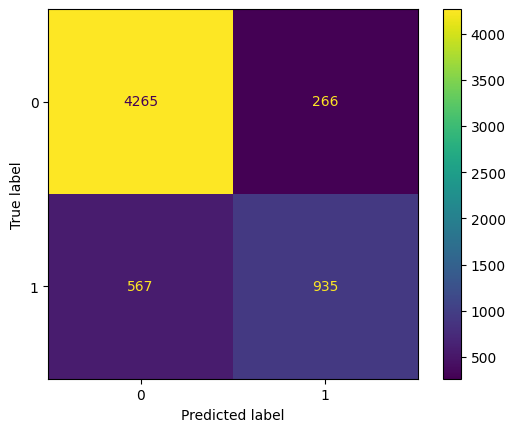

In [43]:
accuracy_real = sklearn.metrics.accuracy_score(test_labels_real, predictions_real)
print(f'Test: {accuracy_real=:.4f}')

cm = sklearn.metrics.confusion_matrix(test_labels_real, predictions_real)
TN = cm[0][0]
FN = cm[1][0]
TP = cm[1][1]
FP = cm[0][1]
print(f"Test: {TP=}, {TN=}, {FP=}, {FN=}")

disp = sklearn.metrics.ConfusionMatrixDisplay(confusion_matrix=cm, )
disp.plot();

In [44]:
explainers_real = TabularExplainer(
    explainers=["ale", "shap_global", "lime", "mace"],                       # The explainers to apply
    mode="classification",                             # The task type
    data=train_tabular_real,                                   # The data for initializing the explainers
    model=model,                              # The ML model to explain
    preprocess=lambda z: transformer.transform(z),     # Converts raw features into the model inputs
    params={
        "mace": {"ignored_features": ["sex_cat_private", "race"]}# params which cannot change when creating counterfactuals
    }
)

/home/sakana/anaconda3/envs/workflow/lib/python3.8/site-packages/sklearn/preprocessing/_discretization.py:257: UserWarning:

Feature 5 is constant and will be replaced with 0.



In [45]:
test_instances_real = test_tabular_real[miss_but_confident]
local_explanations_real = explainers_real.explain(X=test_instances_real)
# global_explanations_real = explainers_real.explain_global()

In [46]:
print(f"There are {len(miss_but_confident)} instances where the model is very confident but wrong: {miss_but_confident}")

There are 40 instances where the model is very confident but wrong: [146, 257, 300, 638, 1040, 1378, 1409, 1426, 1528, 1640, 1847, 2142, 2344, 2351, 2353, 2407, 2530, 2671, 2742, 2903, 3022, 3023, 3247, 3388, 3579, 3868, 3963, 4020, 4065, 4112, 4116, 4379, 4425, 4698, 5012, 5079, 5260, 5549, 5633, 5704]


In [47]:
print("LIME results:")

for i, instance_id in enumerate(miss_but_confident):
    print(f"Instance {instance_id} has label {test_labels_real[instance_id]} and prediction {predictions_real[instance_id]}, with probs {model.predict_proba(test_real[instance_id:instance_id+1])[0]}")
    local_explanations_real["lime"].ipython_plot(index=i, class_names=class_names)
    if i > 10:
        break

LIME results:
Instance 146 has label 1 and prediction 0, with probs [0.95029159 0.04970841]


Instance 257 has label 1 and prediction 0, with probs [0.95770256 0.04229744]


Instance 300 has label 1 and prediction 0, with probs [0.98472442 0.01527558]


Instance 638 has label 1 and prediction 0, with probs [0.98285316 0.01714684]


Instance 1040 has label 1 and prediction 0, with probs [0.98169215 0.01830785]


Instance 1378 has label 0 and prediction 1, with probs [0.00367243 0.99632757]


Instance 1409 has label 1 and prediction 0, with probs [0.96296426 0.03703574]


Instance 1426 has label 1 and prediction 0, with probs [0.95100015 0.04899985]


Instance 1528 has label 1 and prediction 0, with probs [0.98432297 0.01567703]


Instance 1640 has label 1 and prediction 0, with probs [0.98872964 0.01127036]


Instance 1847 has label 1 and prediction 0, with probs [0.97732838 0.02267162]


Instance 2142 has label 1 and prediction 0, with probs [0.97050368 0.02949632]


In [48]:
print("MACE explanation")

for i, instance_id in enumerate(miss_but_confident):

    query_df = local_explanations_real['mace'].get_explanations()[i]['query'].reset_index(drop=True)
    query_df.index = [f"{instance_id}"] * len(query_df)


    counter_df = local_explanations_real['mace'].get_explanations()[i]['counterfactual'].reset_index(drop=True)
    counter_df.index = [ f"CF[{cnt}] for {instance_id}" for cnt in range(len(counter_df))]

    combined_df = pd.concat([query_df, counter_df])
    styled_df = combined_df.style.apply(highlight_changes, axis=1)


    display(styled_df)
    if i > 10:
        break


MACE explanation


,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,capital_gain,capital_loss,hours_per_week,native_country,age_cat_private,sex_cat_private,label
146,State-gov,186634.000000,12th,8.000000,Never-married,Exec-managerial,Not-in-family,White,0.000000,0.000000,50.000000,United-States,0,0.000000,0
CF[0] for 146,State-gov,186634.000000,12th,8.000000,Never-married,Exec-managerial,Not-in-family,White,7915.500000,0.000000,50.000000,United-States,0,0.000000,1


,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,capital_gain,capital_loss,hours_per_week,native_country,age_cat_private,sex_cat_private,label
257,Private,100067.000000,11th,7.000000,Married-civ-spouse,Other-service,Married,Black,0.000000,0.000000,35.000000,United-States,1,0.000000,0
CF[0] for 257,Private,100067.000000,11th,7.000000,Married-civ-spouse,Other-service,Married,Black,5285.500000,0.000000,35.000000,United-States,1,0.000000,1


,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,capital_gain,capital_loss,hours_per_week,native_country,age_cat_private,sex_cat_private,label
300,Self-emp-inc,229498.000000,Some-college,10.000000,Widowed,Sales,Not-in-family,White,0.000000,0.000000,20.000000,United-States,1,0.000000,0
CF[0] for 300,Self-emp-inc,229498.000000,Some-college,10.000000,Widowed,Sales,Not-in-family,White,12499.875000,0.000000,20.000000,United-States,1,0.000000,1


,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,capital_gain,capital_loss,hours_per_week,native_country,age_cat_private,sex_cat_private,label
638,Private,137618.000000,Some-college,10.000000,Never-married,Other-service,Not-in-family,White,0.000000,0.000000,41.000000,United-States,1,0.000000,0
CF[0] for 638,Private,137618.000000,Some-college,10.000000,Never-married,Other-service,Not-in-family,White,8451.000000,0.000000,41.000000,United-States,1,0.000000,1


,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,capital_gain,capital_loss,hours_per_week,native_country,age_cat_private,sex_cat_private,label
1040,Private,186350.000000,HS-grad,9.000000,Widowed,Exec-managerial,Not-in-family,White,0.000000,0.000000,10.000000,United-States,1,0.000000,0
CF[0] for 1040,Private,186350.000000,HS-grad,9.000000,Widowed,Exec-managerial,Not-in-family,White,12499.875000,0.000000,10.000000,United-States,1,0.000000,1


,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,capital_gain,capital_loss,hours_per_week,native_country,age_cat_private,sex_cat_private,label
1378,Self-emp-not-inc,145574.000000,HS-grad,9.000000,Divorced,Exec-managerial,Not-in-family,White,34095.000000,0.000000,60.000000,United-States,1,0.000000,1
CF[0] for 1378,Self-emp-not-inc,145574.000000,HS-grad,9.000000,Divorced,Exec-managerial,Not-in-family,White,6392.812500,0.000000,60.000000,United-States,1,0.000000,0


,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,capital_gain,capital_loss,hours_per_week,native_country,age_cat_private,sex_cat_private,label
1409,State-gov,105728.000000,HS-grad,9.000000,Married-civ-spouse,Other-service,Married,Amer-Indian-Eskimo,0.000000,0.000000,28.000000,United-States,1,0.000000,0
CF[0] for 1409,State-gov,105728.000000,HS-grad,9.000000,Married-civ-spouse,Other-service,Married,Amer-Indian-Eskimo,5285.500000,0.000000,28.000000,United-States,1,0.000000,1


,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,capital_gain,capital_loss,hours_per_week,native_country,age_cat_private,sex_cat_private,label
1426,Self-emp-not-inc,128516.000000,Assoc-acdm,12.000000,Widowed,Sales,Unmarried,White,0.000000,0.000000,40.000000,United-States,1,0.000000,0
CF[0] for 1426,Self-emp-not-inc,128516.000000,Assoc-acdm,12.562500,Widowed,Exec-managerial,Married,White,0.000000,0.000000,40.000000,United-States,1,0.000000,1
CF[1] for 1426,Federal-gov,128516.000000,Assoc-acdm,12.562500,Widowed,Sales,Married,White,0.000000,0.000000,40.000000,United-States,1,0.000000,1
CF[2] for 1426,Self-emp-not-inc,127785.406250,Assoc-acdm,12.562500,Widowed,Exec-managerial,Married,White,0.000000,0.000000,40.000000,United-States,1,0.000000,1
CF[3] for 1426,Federal-gov,127785.406250,Assoc-acdm,12.000000,Married-civ-spouse,Prof-specialty,Unmarried,White,0.000000,1910.250000,40.000000,United-States,1,0.000000,1
CF[4] for 1426,Federal-gov,130309.812500,Masters,12.000000,Married-civ-spouse,Sales,Unmarried,White,3103.000000,0.000000,40.000000,United-States,1,0.000000,1


,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,capital_gain,capital_loss,hours_per_week,native_country,age_cat_private,sex_cat_private,label
1528,Private,33983.000000,Assoc-voc,11.000000,Never-married,Adm-clerical,Not-in-family,White,0.000000,0.000000,42.000000,United-States,1,0.000000,0
CF[0] for 1528,Private,33983.000000,Assoc-voc,12.562500,Married-civ-spouse,Adm-clerical,Married,White,0.000000,0.000000,42.000000,United-States,1,0.000000,1
CF[1] for 1528,Federal-gov,33983.000000,Assoc-voc,11.625000,Married-civ-spouse,Adm-clerical,Married,White,0.000000,0.000000,42.000000,United-States,1,0.000000,1
CF[2] for 1528,Private,33983.000000,Bachelors,12.562500,Married-civ-spouse,Adm-clerical,Married,White,0.000000,0.000000,42.000000,United-States,1,0.000000,1
CF[3] for 1528,Private,33983.000000,Bachelors,11.000000,Never-married,Adm-clerical,Not-in-family,White,7298.000000,97.750000,42.500000,United-States,1,0.000000,1


,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,capital_gain,capital_loss,hours_per_week,native_country,age_cat_private,sex_cat_private,label
1640,Private,94081.000000,HS-grad,9.000000,Never-married,Craft-repair,Not-in-family,White,0.000000,0.000000,40.000000,United-States,1,0.000000,0
CF[0] for 1640,Private,94081.000000,HS-grad,9.000000,Never-married,Craft-repair,Not-in-family,White,12499.875000,0.000000,40.000000,United-States,1,0.000000,1


,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,capital_gain,capital_loss,hours_per_week,native_country,age_cat_private,sex_cat_private,label
1847,Private,134737.000000,Bachelors,13.000000,Never-married,Sales,Own-child,White,0.000000,0.000000,40.000000,United-States,1,0.000000,0
CF[0] for 1847,Private,134737.000000,Bachelors,13.000000,Married-civ-spouse,Sales,Married,White,0.000000,0.000000,40.000000,United-States,1,0.000000,1
CF[1] for 1847,Private,135175.375000,Bachelors,13.000000,Married-civ-spouse,Sales,Married,White,0.000000,0.000000,40.000000,United-States,1,0.000000,1
CF[2] for 1847,Private,135175.375000,Bachelors,13.000000,Married-civ-spouse,Sales,Married,White,0.000000,0.000000,39.875000,United-States,1,0.000000,1
CF[3] for 1847,Private,135175.375000,Bachelors,13.000000,Never-married,Sales,Own-child,White,0.000000,2258.000000,40.000000,United-States,1,0.000000,1
CF[4] for 1847,Private,134737.000000,Bachelors,13.000000,Never-married,Prof-specialty,Own-child,White,7618.875000,0.000000,40.000000,United-States,1,0.000000,1


,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,capital_gain,capital_loss,hours_per_week,native_country,age_cat_private,sex_cat_private,label
2142,Private,85604.000000,HS-grad,9.000000,Divorced,Craft-repair,Not-in-family,White,0.000000,0.000000,40.000000,United-States,1,0.000000,0
CF[0] for 2142,Private,85604.000000,HS-grad,9.000000,Divorced,Craft-repair,Not-in-family,White,12499.875000,0.000000,40.000000,United-States,1,0.000000,1


In [49]:
for i, instance_id in enumerate(miss_but_confident):
    print('\nPRIVATE DATA:')
    print(f'Instance {instance_id} has label {test_labels[instance_id]} and prediction {predictions[instance_id]} with prob {model.predict_proba(test[instance_id:instance_id+1])[0]}')
    print('ORIGINAL DATA:')
    print(f'Instance {instance_id} has label {test_labels_real[instance_id]} and prediction {predictions_real[instance_id]} with prob {model.predict_proba(test_real[instance_id:instance_id+1])[0]}')


PRIVATE DATA:
Instance 146 has label 1 and prediction 0 with prob [0.95221575 0.04778425]
ORIGINAL DATA:
Instance 146 has label 1 and prediction 0 with prob [0.95029159 0.04970841]

PRIVATE DATA:
Instance 257 has label 1 and prediction 0 with prob [0.95770256 0.04229744]
ORIGINAL DATA:
Instance 257 has label 1 and prediction 0 with prob [0.95770256 0.04229744]

PRIVATE DATA:
Instance 300 has label 1 and prediction 0 with prob [0.98472442 0.01527558]
ORIGINAL DATA:
Instance 300 has label 1 and prediction 0 with prob [0.98472442 0.01527558]

PRIVATE DATA:
Instance 638 has label 1 and prediction 0 with prob [0.98285316 0.01714684]
ORIGINAL DATA:
Instance 638 has label 1 and prediction 0 with prob [0.98285316 0.01714684]

PRIVATE DATA:
Instance 1040 has label 1 and prediction 0 with prob [0.98169215 0.01830785]
ORIGINAL DATA:
Instance 1040 has label 1 and prediction 0 with prob [0.98169215 0.01830785]

PRIVATE DATA:
Instance 1378 has label 0 and prediction 1 with prob [0.00418186 0.995818

In [50]:
# local_explanations_real["lime"].ipython_plot(index=i, class_names=class_names)

In [51]:
type(local_explanations_real["lime"])

omnixai.explanations.tabular.feature_importance.FeatureImportance

# LLM

In [154]:
ins = local_explanations_real['lime'].get_explanations()[0]
ins['instance']
# instance, features, values, scores, target_label

,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,capital_gain,capital_loss,hours_per_week,native_country,age_cat_private,sex_cat_private
146,State-gov,186634.0,12th,8.0,Never-married,Exec-managerial,Not-in-family,White,0.0,0.0,50.0,United-States,0,0.0


In [165]:
from openai import OpenAI

client = OpenAI(
    api_key="your-api-key", # not need
    base_url="http://localhost:1234/v1"
)

In [166]:
messages = [
    {"role": "system", "content": "You are a helpful ML explanation assistant for explaining prediction results generated by a machine learning classification model using LIME!"}
]

def get_response(message, messages):
    messages.append({"role": "user", "content": message})
    completion = client.chat.completions.create(
        messages=messages,
        temperature=0.2,
        model="model"
    )
    response = completion.choices[0].message.content
    messages.append({"role": "assistant", "content": response})
    return response, messages

In [153]:
context_prompt =  '''You are a helpful assistant for explaining prediction results generated by a machine learning classification model based on the information provided below. Your answers should be accurate and concise. Firstly, given the following feature importance scores in the format ""feature=value": feature importance score":

"capital_gain = 0.0": score=0.7197
"marital_status = Never-married": score=0.1095
"education_num = 8.0": score=0.0930
"hours_per_week = 50.0": score=-0.0708
"capital_loss = 0.0": score=0.0605
"relationship = Not-in-family": score=0.0551
"occupation = Exec-managerial": score=-0.0537
"workclass = State-gov": score=0.0279
"education = 12th": score=0.0232
"race = White": score=-0.0178

Please explain how these features impact the classifier's decision to label this example as label_0. Also pay attention to the values associated with the features.'''

response, messages = get_response(context_prompt, messages)
print(response)

Based on the feature importance scores, here's a breakdown of how each feature impacts the classifier's decision:

1. **capital_gain = 0.7197**: This feature is highly important in predicting the label "label_0". A positive capital gain score indicates that this individual has a higher chance of being labeled as "label_0", suggesting they are more likely to be successful financially.
2. **marital_status = Never-married**: This feature is also very important, with a score of 0.1095. Being never-married may indicate that this individual is less likely to be labeled as "label_0" due to potential financial instability or other factors.
3. **education_num = 8.0**: A high education level (score of 0.0930) is associated with a lower chance of being labeled as "label_0", suggesting that individuals with higher education may have better financial prospects.
4. **hours_per_week = 50.0**: This feature has a negative score (-0.0708), indicating that working full-time (score of 50 hours/week) is as